In [63]:
import os
import torch
import skimage
import numpy as np
from torch import nn
from matplotlib import colormaps, colors
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.models import resnet101, ResNet101_Weights

from pdn import PDN
from data.cub.cub_dataset import CUBDataset, get_cub_transforms

In [16]:
train_transforms, test_transforms = get_cub_transforms(resolution=448)
dataset_val = CUBDataset(os.path.join('datasets', 'CUB'), num_attrs=312,
                         split='val', transforms=test_transforms)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=8, shuffle=True, num_workers=8)
dataloader_val_iter = iter(dataloader_val)

In [10]:
backbone = resnet101(weights=ResNet101_Weights.DEFAULT)
net = PDN(backbone, num_landmarks=8, num_classes=200)
state_dict = torch.load("checkpoints/pdn_CUB.pt", map_location='cpu')
net.load_state_dict(state_dict)

<All keys matched successfully>

In [52]:
def attn_maps_to_rgb(attn_maps):
    k, h, w = attn_maps.shape
    color_overlay = np.zeros((h, w, 3))
    norm = colors.Normalize(vmin=0, vmax=k)
    cmap = colormaps['Set1']
    for k, map_k in enumerate(attn_maps):
        rgb = cmap(norm(k))[:-1]
        rgb_arr = np.expand_dims(np.array(rgb), axis=(0, 1))
        color_overlay += map_k[..., np.newaxis] * rgb_arr
    return color_overlay

In [79]:
COLORS = [[0.75,0,0],[0,0.75,0],[0,0,0.75],[0.5,0.5,0],[0.5,0,0.5],[0,0.5,0.5],[0.75,0.25,0],[0.75,0,0.25],[0,0.75,0.25],
    [0.75,0,0],[0,0.75,0],[0,0,0.75],[0.5,0.5,0],[0.5,0,0.5],[0,0.5,0.5],[0.75,0.25,0],[0.75,0,0.25],[0,0.75,0.25],
    [0.75,0,0],[0,0.75,0],[0,0,0.75],[0.5,0.5,0],[0.5,0,0.5],[0,0.5,0.5],[0.75,0.25,0],[0.75,0,0.25],[0,0.75,0.25]]

def landmarks_to_rgb(maps):
    k, h, w = attn_map.shape
    rgb = np.zeros((h, w, 3))
    for m in range(k):
        for c in range(3):
            rgb[:, :, c] += maps[m, :, :] * COLORS[m % 25][c]
    return rgb

def save_maps(images: torch.Tensor, attn_maps: torch.Tensor, epoch: int, model_name: str, device: torch.device) -> None:
    b, k, h, w = attn_maps.shape
    grid_x, grid_y = torch.meshgrid(torch.arange(w), torch.arange(h), indexing='xy')

    grid_x = grid_x[None, None, ...].to(attn_maps.device)
    grid_y = grid_y[None, None, ...].to(attn_maps.device)

    attn_map_sums = attn_maps.sum((-1, -2)).detach()
    cx = torch.sum(grid_x * attn_maps, dim=(-1, -2)) / attn_map_sums
    cy = torch.sum(grid_y * attn_maps, dim=(-1, -2)) / attn_map_sums
    
    vis_size = (448, 448)

    fig, axs = plt.subplots(3, 3, dpi=150)
    for i, ax in enumerate(axs.flatten()):
        if i < attn_maps.shape[0]:
            image = images[i, ...].permute(1, 2, 0).numpy()
            color_overlay = attn_maps_to_rgb(attn_maps[i, :-1, ...].numpy())
            # img_with_landmarks = skimage.transform.resize(color_overlay, vis_size) * 0.5 +\
            #                      skimage.transform.resize(images[i, ...].permute(1, 2, 0).numpy(), vis_size) * 0.5
            img_with_landmarks = skimage.transform.resize(color_overlay, vis_size) * 0.5 +\
                                 image * 0.8
            ax.imshow(np.clip(img_with_landmarks, a_min=0, a_max=1))
            x_coords = cx[i, 0:-1] * 448 / w
            y_coords = cy[i, 0:-1] * 448 / h
            cols = COLORS[0: k - 1]
            n = np.arange(k)
            for xi, yi, col_i, mark in zip(x_coords, y_coords, cols, n):
                ax.scatter(xi, yi, color=col_i, marker=f'${mark}$')
        ax.set_xticks([])
        ax.set_yticks([])

In [17]:
device = 'cpu'
net.eval()

with torch.no_grad():
    batch = next(dataloader_val_iter)
    outputs = net(batch['pixel_values'])

In [19]:
list(outputs.keys())

['class_scores', 'attn_maps', 'part_features']

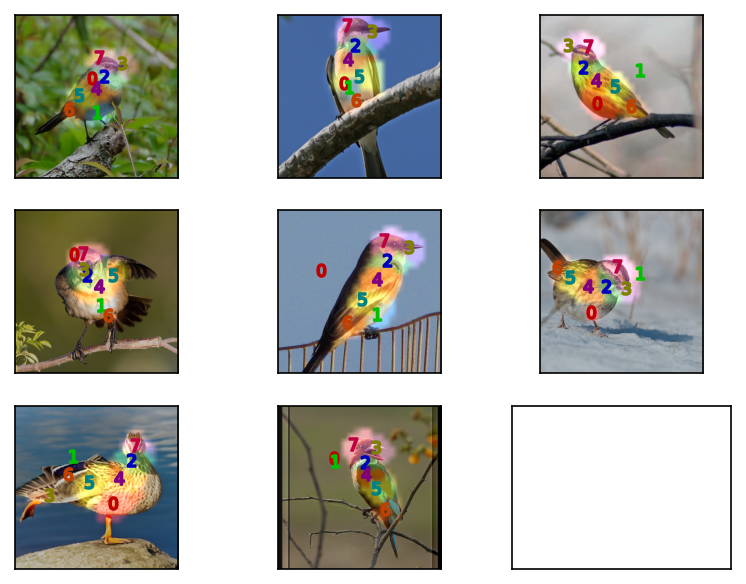

In [80]:
save_maps(batch['pixel_values'], outputs['attn_maps'], 0, 'cub_interpolate', torch.device('cpu'))